In [31]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time

In [32]:
class CoherenceGraph(object):
    """
    The CoherenceGraph consists of nodes that are either true or false and have negative and positive constrains in between.
    Accepts a list of nodes (s) that are accepted to be true from the start
    Can compute its coherence (W), which is a weighted sum of satisfied constrains
    """
    def __init__(self,n,observed=[], seed=89, inhibitory_fraction=0.5):
        self.n = n               # total number of nodes
        self.v = np.zeros((n))   # truth assignment of all nodes 1 for True, -1 for False
        self.observed = [e for e in observed if e < self.n] # list of indecies of nodes that are set to be true
        self.c = self.initConnections(seed, inhibitory_fraction)   # connections between nodes
        self.W = None
            
    def initConnections(self, seed, inhibitory_fraction):
        """
        Randomly select from positive or negative constrains, weighted between -1,1
        All excitatory connections are set to 0.4 (except for special elements s to 0.5)
        All inhibitory connections to -0.6
        """
        np.random.seed(seed)    
        # initialize the weights between (0,1) for inh_frac=0, (-0.5,0.5) for inh_frac=0.5 and (-1,0) for inh_frac=1
        c = np.random.rand(self.n, self.n) - inhibitory_fraction
        for i in range(c.shape[0]):
            for j in range(c.shape[1]):
                c[i][j] = c[j][i]  # make symmetric
        c = np.where(c>0, 0.4, c)  # set all excitatory connections to 0.4
        c = np.where(c<0,-0.6, c)  # set all inhibitory connections to -0.6
        c[self.observed,:] = 0.5   # Set all d to s connections to 0.5 
        c[:,self.observed] = 0.5
        diag = np.arange(self.n)
        c[diag,diag] = 0           # Remove self connections
        return c
        
    def computeW(self):
        """
        Compute the coherence(W/W*) for one assignment of nodes
        """
        E = np.where(self.v > 0, 1, -1)
        # theshold the connections to only -1,1
        binary_weights = np.where(self.c > 0, 1, self.c)
        binary_weights = np.where(binary_weights < 0, -1, binary_weights)
        W = np.sum(binary_weights * np.dot(E.reshape(-1,1), E.reshape(1,-1)))   # W = C * E * E
        self.W = W
        if np.sum(binary_weights) != 0:
            self.W = self.W / np.sum(binary_weights) # W / W*
        return self.W   
        
    def setV(self, v):
        self.v = v
        
    def setObserved(self, observed):
        self.observed = [e for e in observed if e < self.n] # set only valid elements for s
        

In [33]:
class ExhaustiveSearch(object):
    """
    Exhaustive search - algorithm to compute coherence
    1. Generate all possible ways of dividing elements into accepted and rejected.
    2. Evaluate each of these for the extent to which it achieves coherence. (in other words compute W for each partition)
    3. Pick the one with highest value of W.
    """
    
    def __init__(self, graph):
        self.graph = graph
        self.subsets = self.finalSubsets()
        self.Ws = None
        self.Wmax = None
        self.Emax = None
        
    def allSubsets(self):
        """
        Generate all possible subsets of accepted(+1) and rejected(-1) elements
        """
        n = self.graph.n
        subsets = np.zeros((2**n,n))
        for i in range(2**n):
            binary = np.array(list(bin(i)[2:])).astype(float)
            if binary.shape[0] < n:
                padding  = np.zeros(n-binary.shape[0])
                subsets[i,:] = np.append(padding, binary)
            else:
                subsets[i,:] = binary
        return np.where(subsets > 0, 1, -1)
        
    def finalSubsets(self):
        """
        Remove subsets that are inconsistent with what we know to be true (s)
        """
        subs = self.allSubsets()
        for s in self.graph.observed:
            subs = subs[subs[:,s] == 1,] # remove subsets where values in s are not True
        return subs
    
    def search(self):
        """
        For all possible subsets, compute the cohence and store it in array
        """
        W = np.zeros((self.subsets.shape[0],))  
        for i,E in enumerate(self.subsets):
            self.graph.setV(E)  # set the nodes to their values
            W[i] = self.graph.computeW()
        self.Ws = W
        
    def getOptimalSolution(self):
        """
        Get W and truth assignmnets of nodes for max W
        """
        max_index = np.argmax(self.Ws)
        self.Wmax = self.Ws[max_index]
        self.Emax = self.subsets[max_index]
        return (self.Wmax, self.Emax)
            

In [34]:
class ConnectionistModel(object):
    """
    Algorithm 3: Connectionists
    1. Initialize units (U for each element of E) to small positive value
    2. Initialize weighted edges in accordance with the constrain rules
    3. while units are not settled:
        update units according to the harmony equation
    4. theshold the units with 0 - accepted are positive, rejected are negative
    """
    
    def __init__(self, graph, initState=0.05, numCycles=200, min_max=(-1,1), decay=0.05):
        self.graph = graph
        self.initState = initState   # the start value of the undecided units
        self.numCycles = numCycles   # total number of cycles 
        self.min_max = min_max       # min and max value of a unit
        self.decay = decay           # how much the previous decays during a cycle
        self.units = None            # initial units in updateGraph taking into account the initState and s,       
        
    def initUnits(self):
        v_init = np.repeat(self.initState, self.graph.n) # make array lenght n filled with unit_value
        v_init[self.graph.observed] = 1                     # set the special elements of s to true
        self.units = v_init
        
    def updateGraph(self):
        """
        Implement the connectionist network update into a stable state
        """
        self.initUnits()
        v = self.units.copy()
        v_old = v.copy() * 100 # initial value so it will skip the first break
        for step in range(self.numCycles): # for total number of cycles
            # keep the old version of v for paralel updating
            # if v_old and v every element differnce < 0.001, then stop
            if np.all(np.abs(v_old - v) < 0.001):
                break
            # assign to v_old v from the previous step
            v_old = v.copy()
            for i in range(self.graph.n): # for every unit in the graph
                if i not in self.graph.observed: # if the unit is not a special fixed value s
                    net = np.dot(v_old, self.graph.c[i]) # compute total flow to the unit
                    if net > 0:
                        gradient = net*(self.min_max[1]-v_old[i])
                    else:
                        gradient = net*(v_old[i]-self.min_max[0])
                    v[i] = v_old[i]*(1-self.decay) + gradient
            # should this be after every unit update, or after the whole graph updates ??
            v = np.where(v>1, self.min_max[1], v)
            v = np.where(v<-1,self.min_max[0],v)
        self.units = v
        
    def getSolution(self):
        # theshold and compute final W
        v = np.where(self.units > 0, 1, -1)
        self.graph.setV(v)
        self.graph.computeW()
        return (self.graph.W, self.graph.v)
        

In [36]:
"""
Test and compare the 2 algorithms
"""
# Simple Matching Coefficient 
def SMC(E1, E2):
    #Compute fraction of shared elements for 2 ndarrays
    return np.sum(E1 == E2) / E1.shape[0]


"""
For the TA, if you want to modify this...

NUM_NODES - all different number of nodes on the graph to test with, don't run with more than 18 - takes minutes
INHIBITORY_FRACTIONS - Fracions of constrains set to negative/inhibitory, 
                       0.0 - all constrains are positive, 0.5 - equal number of positive and negative, 1.0 - all constrains are negative
OBSERVED - set of index of nodes that are set to be true 
"""
NUM_NODES = range(3, 19, 3)   
INHIBITORY_FRACTIONS = [0.0, 0.25, 0.5, 0.75, 1.]  
OBSERVED = [1,2]

# For data collection
data_size = (len(NUM_NODES), len(INHIBITORY_FRACTIONS))
data = {
    'node_similarity' : np.zeros(data_size), # Simple matching coefficient between the truth assignments of the 2 algorithms
    'coherence' : np.zeros(data_size), # Coherence for the exhaustive search over all runs
    'harmony' : np.zeros(data_size), # Harmony from the connectionist model
    'exhTimes' : np.zeros(data_size), # Runtime for the exhausitve search
    'conTimes' : np.zeros(data_size) # Runtime for connectionist model
}


for i,n in enumerate(NUM_NODES):  # for different number of nodes        
    for j,inhib_frac in enumerate(INHIBITORY_FRACTIONS): # for different fraction of inhibitory links / negative constrains
        
        # Create a graph with n number of nodes, where the s nodes are always true, with random seed for constrains seed
        G = CoherenceGraph(n=n,                            # number of nodes
                           observed=OBSERVED,              # observed elements 
                           seed=89,                        # random seed for the constrains 
                           inhibitory_fraction=inhib_frac) # relative fraction of inhibitory links / negative constrains
        
        start = time.time()
        # Exhaustive search
        ExCoh = ExhaustiveSearch(G) # create exhausive seach with the graph
        ExCoh.search()              # compute W for all possible subsets
        Wmax, Emax = ExCoh.getOptimalSolution() # get the max W and the truth assigments that achieves it
        data['exhTimes'][i][j] = time.time()-start
        data['coherence'][i][j] = Wmax
        
        start = time.time()
        # Connectionist model
        ConCoh = ConnectionistModel(G,               
                                    initState=0.1,   
                                    numCycles=200,   
                                    min_max=(-1,1),  
                                    decay=0.05) 
        ConCoh.updateGraph()
        harmony, Econ = ConCoh.getSolution() # get the final state of the 
        data['conTimes'][i][j] = time.time()-start
        data['harmony'][i][j] = harmony
        
        # Track truth assignment difference and coherence / harmony fraction
        data['node_similarity'][i][j] = SMC(Emax, Econ)
        
        


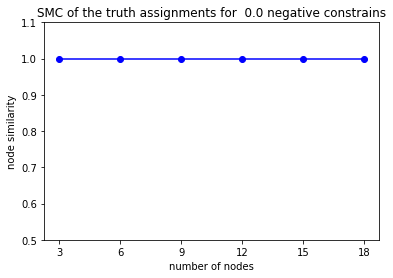

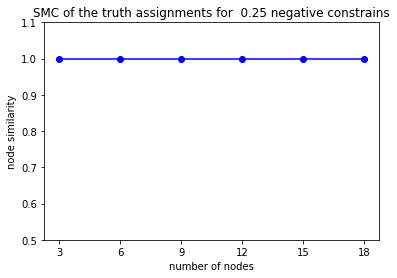

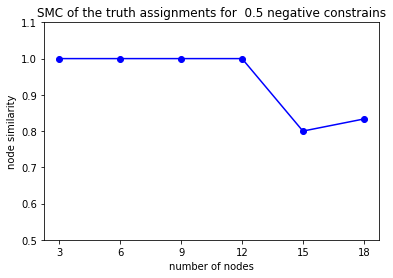

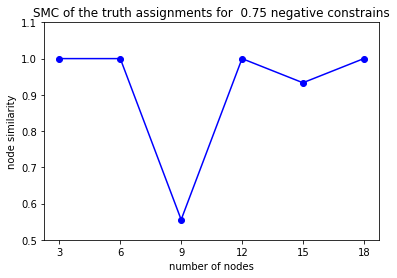

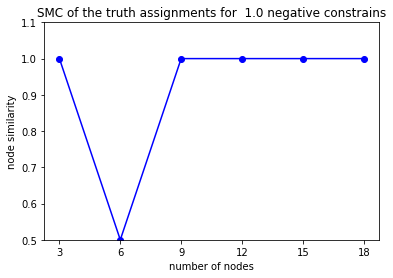

In [40]:
# Plot simple matching coefficient between the truth assignments of the different algorithms
for i, inh in enumerate(INHIBITORY_FRACTIONS):
    plt.plot(NUM_NODES,data['node_similarity'][:,i], '-o', color='b')
    plt.ylim([0.5,1.1])
    plt.title("SMC of the truth assignments for  {} negative constrains".format(inh))
    plt.xticks(list(NUM_NODES))
    plt.xlabel("number of nodes")
    plt.ylabel("node similarity")
    plt.savefig('SMC{}.png'.format(inh))
    plt.show()

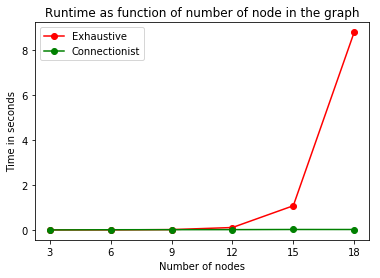

In [38]:
# Plot a comparison of the runtimes of both algorithms
exhTimesLine = plt.plot(NUM_NODES, np.mean(data['exhTimes'], axis=1), '-o', color='r', label='Exhaustive')
conTimesLine = plt.plot(NUM_NODES, np.mean(data['conTimes'], axis=1), '-o', color='g', label='Connectionist')
plt.xlabel("Number of nodes")
plt.ylabel("Time in seconds")
plt.title("Runtime as function of number of node in the graph")
plt.xticks(list(NUM_NODES))
plt.legend()
plt.savefig("RuntimeComparison.png")
plt.show()

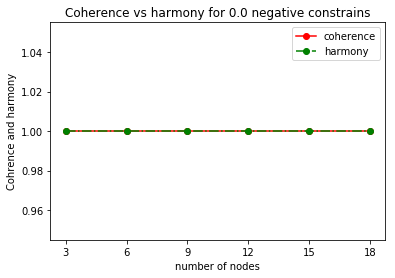

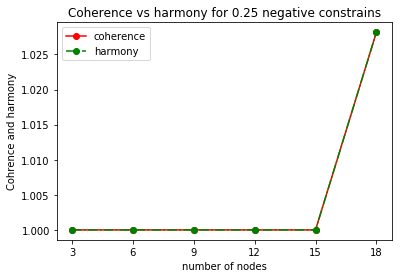

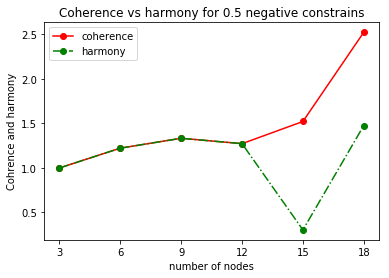

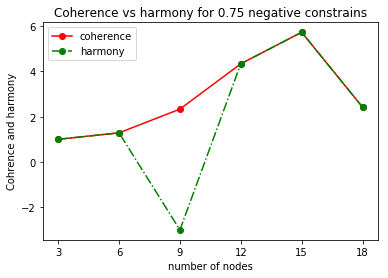

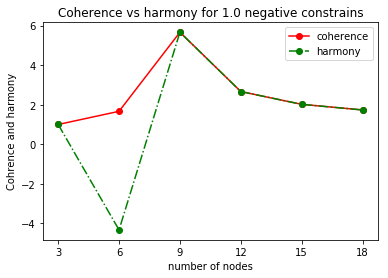

In [39]:
# Compare coherence and harmony for each number of nodes and inhibitory fractions
for i, inh in enumerate(INHIBITORY_FRACTIONS):
    plt.plot(NUM_NODES,data['coherence'][:,i], '-o', color='r', label='coherence')
    plt.plot(NUM_NODES,data['harmony'][:,i], '-.o', color='g', label='harmony')
    plt.title("Coherence vs harmony for {} negative constrains".format(inh))
    plt.legend()
    plt.xlabel("number of nodes")
    plt.xticks(list(NUM_NODES))
    plt.ylabel("Cohrence and harmony")
    plt.savefig('NodeSimilarityFor{}.png'.format(inh))
    plt.show()